In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('datasets/telco.csv', parse_dates=['date'])

sample = data.sample(5)
sample

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,date,activity,Churn
4623,8755-IWJHN,Male,1,Yes,No,69.0,Yes,Yes,Fiber optic,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.35,6382,2022-02-01,active,No
4890,3162-ZJZFU,Male,0,Yes,Yes,NaN,Yes,No,Fiber optic,No,...,Yes,No,Month-to-month,Yes,Electronic check,92.55,4779.45,2022-02-01,active,No
6347,7718-RXDGG,Male,0,Yes,No,15.0,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Bank transfer (automatic),68.60,1108.6,2022-02-01,active,No
3270,4132-KALRO,Female,0,No,No,NaN,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Mailed check,100.85,399.25,2022-02-01,active,No
4207,8706-HRADD,Male,0,No,No,21.0,No,No phone service,DSL,Yes,...,Yes,No,Month-to-month,Yes,Mailed check,43.55,1011.5,2022-02-01,active,No


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   tenure            5640 non-null   float64       
 6   PhoneService      7043 non-null   object        
 7   MultipleLines     7043 non-null   object        
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

In [3]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

In [4]:
# Check data for missing values
data.isnull().sum().sort_values(ascending=False)

tenure              1403
TotalCharges          11
customerID             0
TechSupport            0
activity               0
date                   0
MonthlyCharges         0
PaymentMethod          0
PaperlessBilling       0
Contract               0
StreamingMovies        0
StreamingTV            0
DeviceProtection       0
gender                 0
OnlineBackup           0
OnlineSecurity         0
InternetService        0
MultipleLines          0
PhoneService           0
Dependents             0
Partner                0
SeniorCitizen          0
Churn                  0
dtype: int64

In [5]:
data['tenure'] = data['tenure'].ffill()
data = data.dropna(subset=['TotalCharges'])

Let us compare the rate of churn for different categories

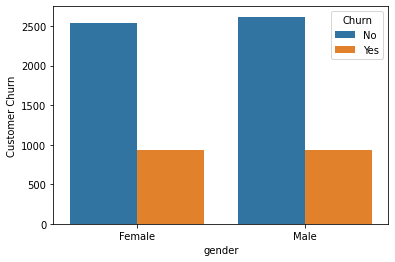

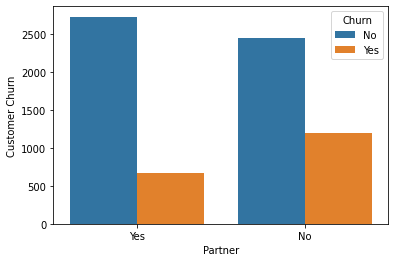

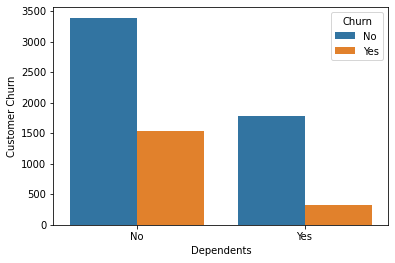

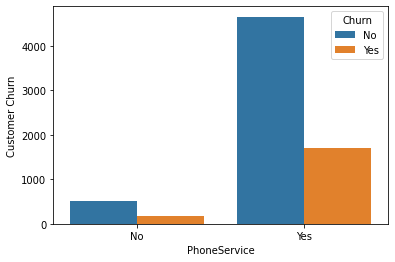

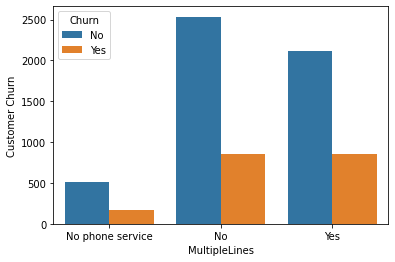

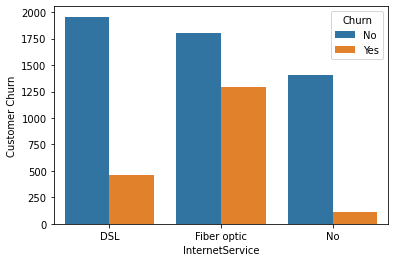

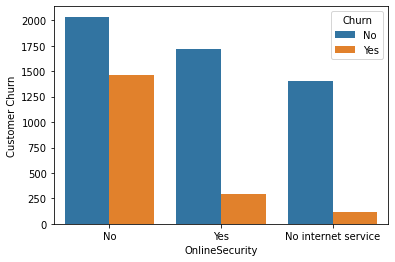

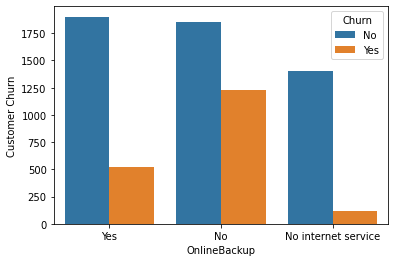

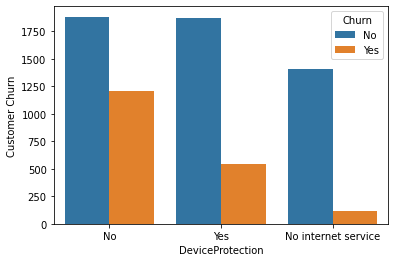

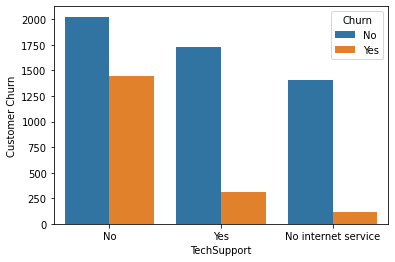

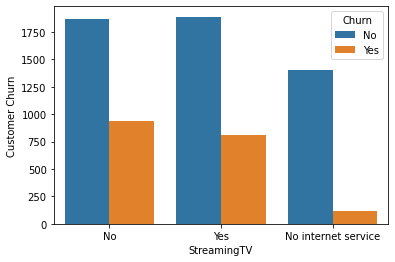

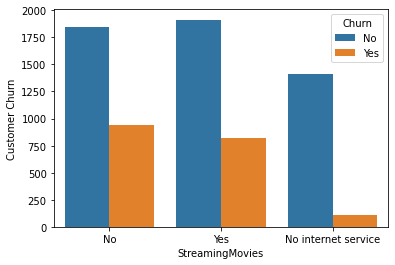

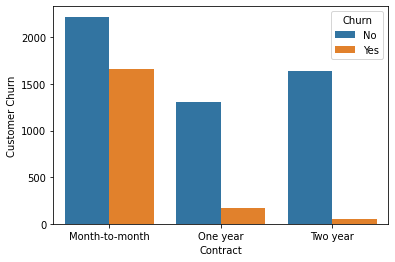

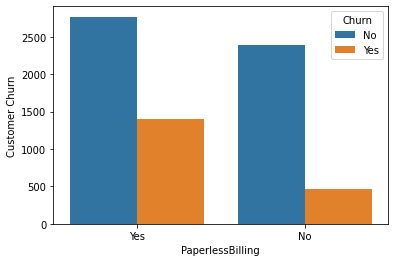

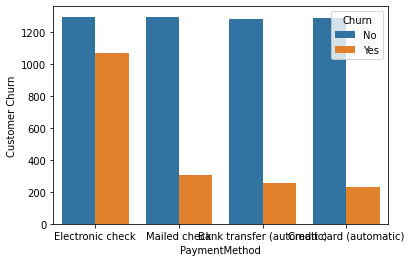

In [6]:
categorical_cols = [col for col in data if data[col].dtype in ['object']]
categorical_cols = categorical_cols[1:-2]
for col in categorical_cols:
    sns.countplot(x=data[col], hue=data['Churn'])
    plt.xlabel(col)
    plt.ylabel('Customer Churn')
    plt.show()


In [7]:
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [8]:
month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Map numeric month values to month names
data['month'] = data['month'].map(month_names)

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,date,activity,Churn,month,day
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,2022-02-01 00:00:00,inactive,No,February,1
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,2022-02-01 00:00:00,active,No,February,1
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,2022-02-01 00:00:00,inactive,Yes,February,1
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,2022-04-24 17:19:00,active,No,April,24
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,2022-02-01 00:00:00,inactive,Yes,February,1


Churn is far less in April than it is in February, why is that?


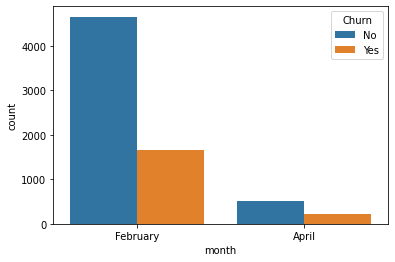

In [9]:
sns.countplot(x='month',hue='Churn', data=data)
plt.show()

Let us check in which month churn rate is higher, it turns out to be April

In [10]:
churn_rate = data.groupby('month')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
churn_rate = churn_rate.map('{:.2f}%'.format)
print(churn_rate)

month
April       29.26%
February    26.27%
Name: Churn, dtype: object


## Further Exploration

As you can see, majority of the data comprises young people

Text(0.5, 1.0, '% of Senior Citizens')

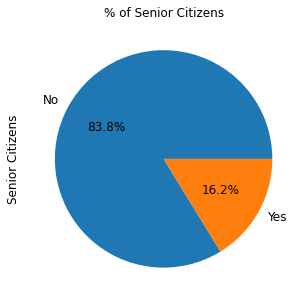

In [11]:
import matplotlib.ticker as mtick
ax = (data['SeniorCitizen'].value_counts()*100.0 /len(data))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

Let us look at the customers by partners and dependents

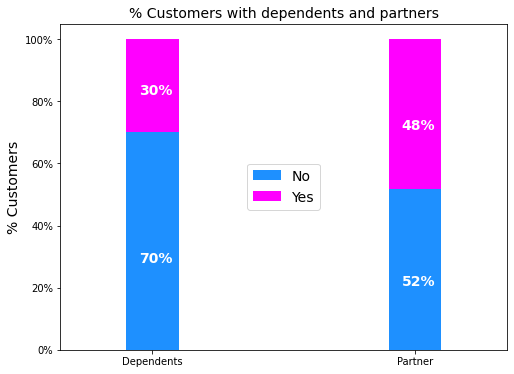

In [12]:
df2 = pd.melt(data, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(data)
colors = ['dodgerblue','fuchsia']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)


Let us look at something more interesting, the percentage of customers who have both partners and dependents

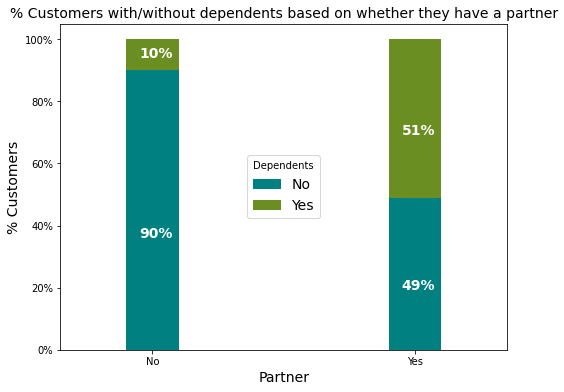

In [13]:
colors = ['teal','olivedrab']
partner_dependents = data.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Now to look at the distribution of various services among customers

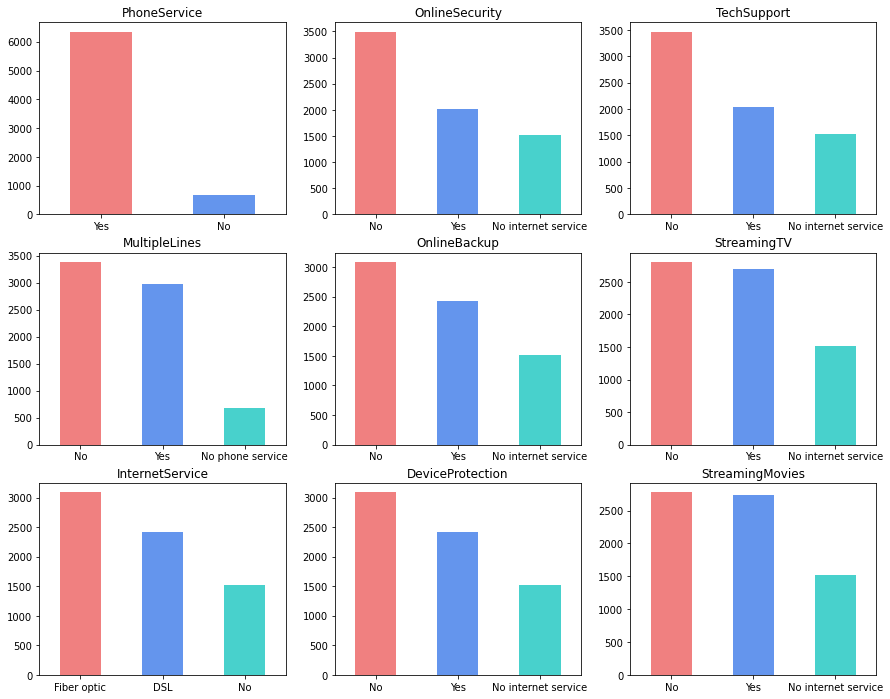

In [14]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
        
colors = ['lightcoral','cornflowerblue','mediumturquoise']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i,0],color=colors,rot = 0)
        
    elif i >=3 and i < 6:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],color=colors,rot = 0)
        
    elif i < 9:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],color=colors,rot = 0)
    ax.set_title(item)

Let us probe into the relationship of some these categories to churn rate

1. Churn by Contract Rate: Customers with month-to-month contract churn a lot

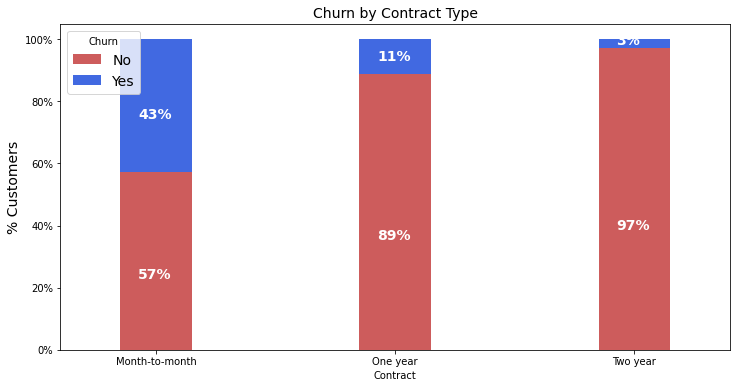

In [15]:
colors = ['indianred','royalblue']
contract_churn = data.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

 2. Churn rate by Payment Method

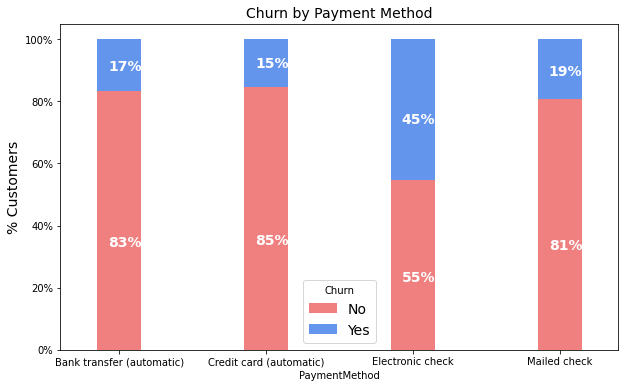

In [29]:
colors = ['lightcoral','cornflowerblue']
payment_churn = data.groupby(['PaymentMethod','Churn']).size().unstack()

ax = (payment_churn.T*100.0 / payment_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Payment Method',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

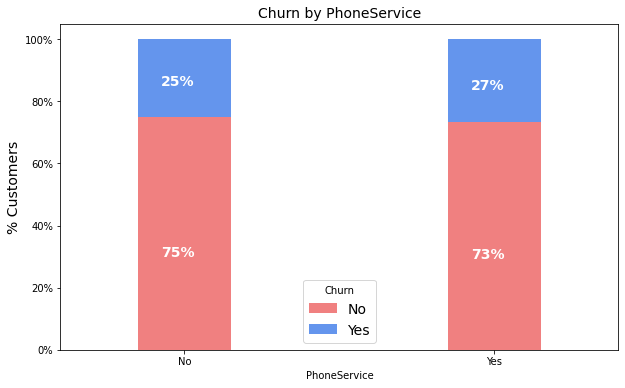

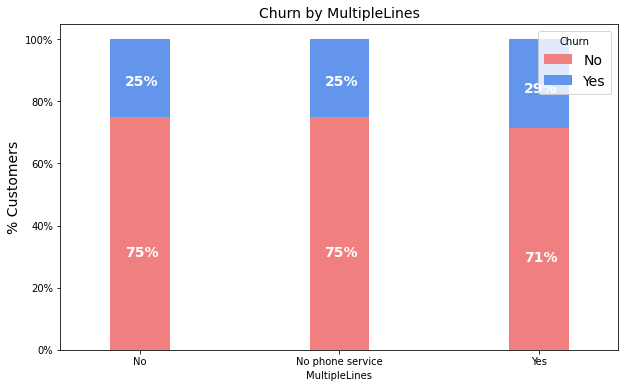

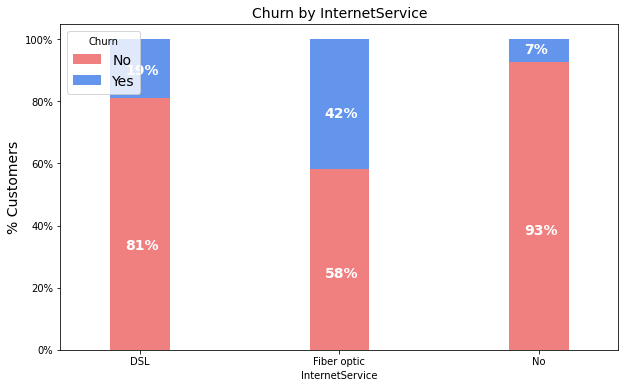

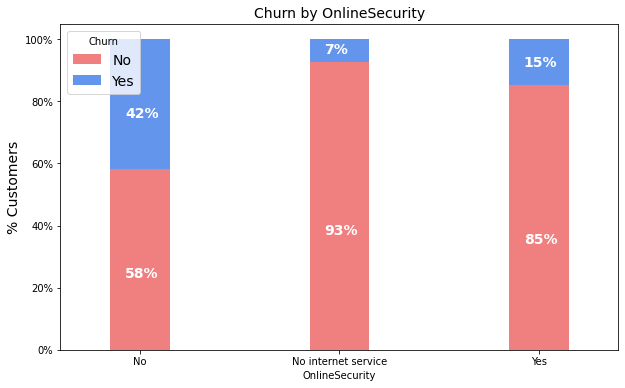

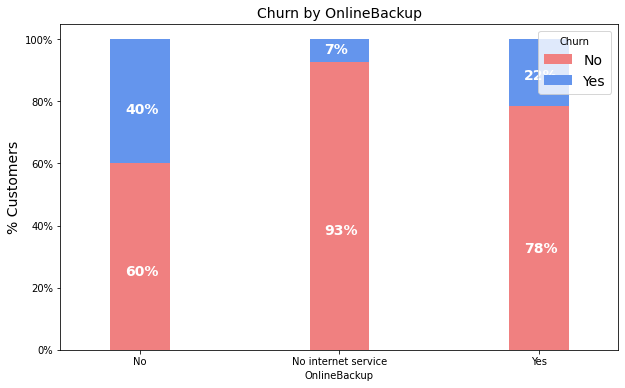

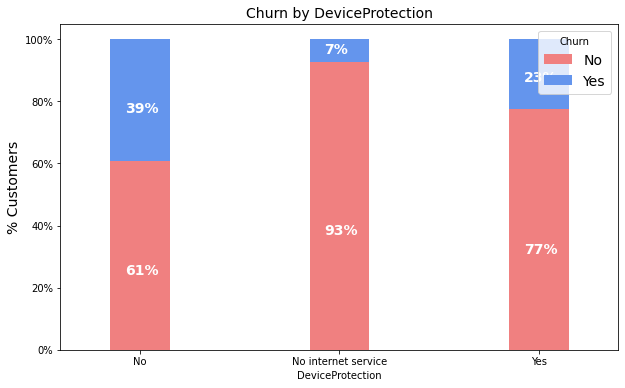

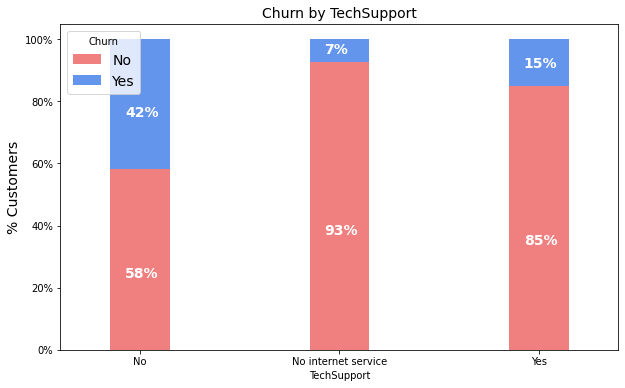

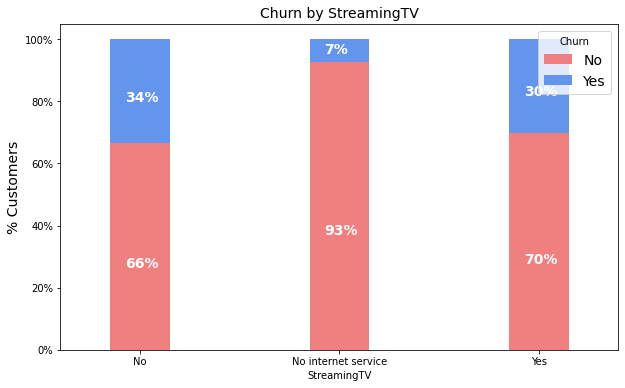

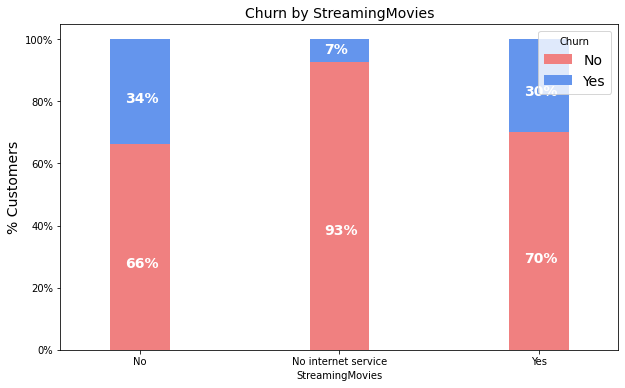

In [17]:
for service in services:
    colors = ['lightcoral','cornflowerblue']
    service_churn = data.groupby([service,'Churn']).size().unstack()

    ax = (service_churn.T*100.0 / service_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc='best',prop={'size':14},title = 'Churn')
    ax.set_ylabel('% Customers',size = 14)
    ax.set_title(f'Churn by {service}',size = 14)

    # Code to add the data labels on the stacked bar chart
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                    color = 'white',
                   weight = 'bold',
                   size = 14)

Observe the distribution of numerical features

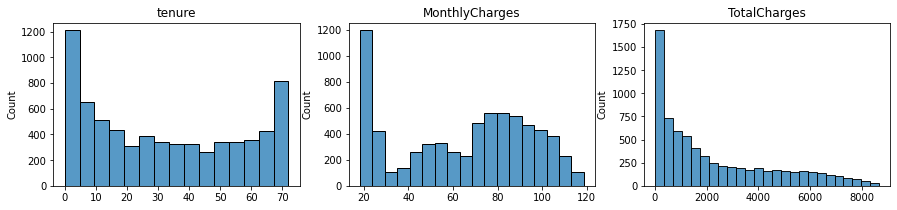

In [18]:
fig,axes=plt.subplots(1,3, figsize=(15, 3))
numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']

ax = sns.histplot(data['tenure'].values, ax=axes[0]).set_title('tenure')
ax = sns.histplot(data['MonthlyCharges'].values, ax=axes[1]).set_title('MonthlyCharges')
ax = sns.histplot(data['TotalCharges'].values, ax=axes[2]).set_title('TotalCharges')

As we can see our data is not balanced, we can solve this different methods, in this case we choose over sampling

In [19]:
feature_cols = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract', 'PaperlessBilling','PaymentMethod','TotalCharges',
 'activity','tenure','MonthlyCharges']

label_cols = 'Churn'

features , label = data[feature_cols], data[label_cols]

In [20]:
np.unique(label,return_counts=True)

(array(['No', 'Yes'], dtype=object), array([5163, 1869]))

In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

train_data = data.copy()
train_data = train_data.drop(['customerID','date','month','day'], axis=1)

categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
              'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
              'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod','activity','Churn']


In [22]:
le = LabelEncoder()
for col in categorical_features:
    train_data[col] = le.fit_transform(train_data[col])
    print(col,' : ',train_data[col].unique(),' = ',le.inverse_transform(train_data[col].unique()))

gender  :  [0 1]  =  ['Female' 'Male']
SeniorCitizen  :  [0 1]  =  [0 1]
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
activity  :  [1 0]  =  ['inactive' 'active']
Churn  :  [0 1]  =  ['No

In [23]:
train_data = pd.get_dummies(train_data,columns=categorical_features[:-1],drop_first=True)

In [24]:
train_data.sample(5)

,tenure,MonthlyCharges,TotalCharges,Churn,gender_1,SeniorCitizen_1,Partner_1,Dependents_1,PhoneService_1,MultipleLines_1,...,StreamingTV_2,StreamingMovies_1,StreamingMovies_2,Contract_1,Contract_2,PaperlessBilling_1,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,activity_1
6745,54.0,100.10,5440.90,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,1,0,1
4280,25.0,19.70,1274.05,0,1,0,1,1,1,0,...,0,1,0,0,1,1,0,0,0,0
5568,44.0,95.10,4060.55,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
6441,17.0,55.35,920.50,0,0,0,1,1,1,0,...,0,0,0,0,0,1,1,0,0,0
5414,64.0,105.65,6903.10,1,1,0,0,0,1,0,...,1,0,1,1,0,1,1,0,0,1


In [25]:
df1 = train_data.copy()
df2 = train_data.copy()

In [26]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X = df1.drop(['Churn','MonthlyCharges','TotalCharges','tenure'], axis=1).values
y = df1['Churn'].values

ros = RandomOverSampler(sampling_strategy="not majority") 
x_res, y_res = ros.fit_resample(X,y)


X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.3, random_state=0)
print(f"Training cases:{X_train.shape[0]}\nTest cases:{X_test.shape[0]}")


Training cases:7228
Test cases:3098


In [27]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,recall_score,precision_score,roc_auc_score,roc_curve

svc = SVC(probability=True)
model = svc.fit(X_train, y_train)
predictions = model.predict(X_test)


Overall Accuracy: 0.9318915429309231
Overall Precision: 0.8930450029222676
Overall Recall: 0.9820051413881749
AUC: 0.9619399321150044
[[1359  183]
 [  28 1528]]


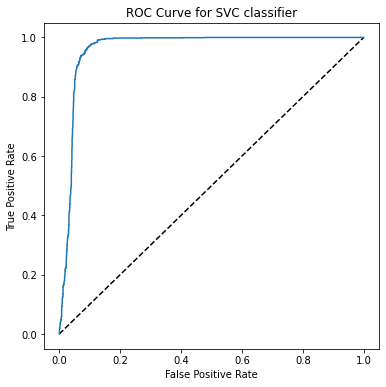

In [28]:
y_scores = model.predict_proba(X_test)
print("Overall Accuracy:",accuracy_score(y_test, predictions))
print("Overall Precision:", precision_score(y_test, predictions))
print("Overall Recall:", recall_score(y_test,predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

churn_classes = ['Yes','No']
# Confusion matrix
mcm = confusion_matrix(y_test,predictions)
print(mcm)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve for SVC classifier")
plt.show()